---

# Georgios_Ioannou


## Copyright © 2023 by Georgios Ioannou


---

<h1 align="center"> Text Emotion System Sentiment Analysis </h1>
<h2 align="center"> TESSA </h2>

In this notebook, we will be classifying emotion based on text documents. The dataset we will be using is called:

<p style="text-align: center;"><a href="https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp">Emotions Dataset for NLP</a></p>


---

<h2 align="center"> Remember our main steps motto "ISBE" </h2>

<h3 align="center"> Main Steps when building a Machine Learning Model </h3>

1. **I** - `Inspect and explore data`
2. **S** - `Select and engineer features`
3. **B** - `Build and train model`
4. **E** - `Evaluate model`


---

<h2 align='center'> GPU Information </h2>


In [1]:
!nvidia-smi


Wed Dec 20 08:15:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---

<h2 align='center'> Libraries </h2>


In [2]:
# Import libraries.

# Use inline so our visualizations display in notebook.


%matplotlib inline


import matplotlib.pyplot as plt   # Data visualization.
import nltk                       # Natural Language Processing.
import numpy as np                # Data wrangling.
import os                         # Manipulate operating system interfaces.
import pandas as pd               # Data handling.
pd.set_option('display.max_colwidth', None)
import pickle                     # Python object serialization.
import plotly.express as px       # Data visualization
import plotly.graph_objects as go # Data visualization
import re                         # Regular expression operations.
import seaborn as sns             # Data visualization.
import subprocess                 # To download nltk wordnet in Kaggle.
sns.set()
import warnings                   # Ignore all warnings.
warnings.filterwarnings('ignore')


from nltk.stem import WordNetLemmatizer # Lemmatize using WordNet's built-in morphy function.
from nltk.stem import PorterStemmer     # Remove morphological affixes from words, leaving only the word stem.
from nltk.corpus import stopwords       # Remove stopwaords.
from nltk import word_tokenize          # Tokenize.
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, multilabel_confusion_matrix, precision_score, recall_score # Evaluation metrics.
from sklearn.model_selection import train_test_split     # Eplit data in training/validating/testing.
from sklearn.naive_bayes import MultinomialNB            # Multinomial Naive Bayes classifier.
from sklearn.preprocessing import LabelEncoder           # Encode target labels with value between 0 and n_classes-1.
from tensorflow.keras.callbacks import EarlyStopping     # Stop training when a monitored metric has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau # Reduce learning rate when a metric has stopped improving.
from tensorflow.keras.layers import Activation, BatchNormalization, Bidirectional, Concatenate, Conv1D, Dense, Dropout, Embedding, GlobalMaxPooling1D, LSTM, MaxPooling1D, ReLU # Keras layers API.
from tensorflow.keras.models import Model, Sequential # Model achitecture.
from tensorflow.keras.optimizers import Adam         # Adam optimizer.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Transformsa list of sequences into a 2D Numpy array.
from tensorflow.keras.preprocessing.text import Tokenizer         # Vectorize a text corpus.
from tensorflow.keras.utils import plot_model                     # Visualize the model and save it.
from tensorflow.keras.utils import to_categorical                 # Converts a class vector (integers) to binary class matrix.


try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = 'unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora'
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    

from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

True

---

## #3 Build And Train Bidirectional LSTM Model


In [36]:
# Bidirectional LSTM Model Hyperparameters.

# Embedding.

input_dim = vocabulary_size
output_dim = 200

# LSTM.

lstm_first_output_size = 80
lstm_second_output_size = 160

In [37]:
# Create the neural network.

model = Sequential()

# X_train.shape[1] = 256
model.add(Embedding(input_dim, output_dim, input_length=X_train.shape[1]))

model.add(Dropout(0.6))

model.add(Bidirectional(LSTM(lstm_first_output_size, return_sequences=True)))

model.add(Bidirectional(LSTM(lstm_second_output_size)))

model.add(Dense(6, activation="softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          2865200   
                                                                 
 dropout (Dropout)           (None, 256, 200)          0         
                                                                 
 bidirectional (Bidirection  (None, 256, 160)          179840    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 320)               410880    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1926      
                                                                 
Total params: 3457846 (13.19 MB)
Trainable params: 34578

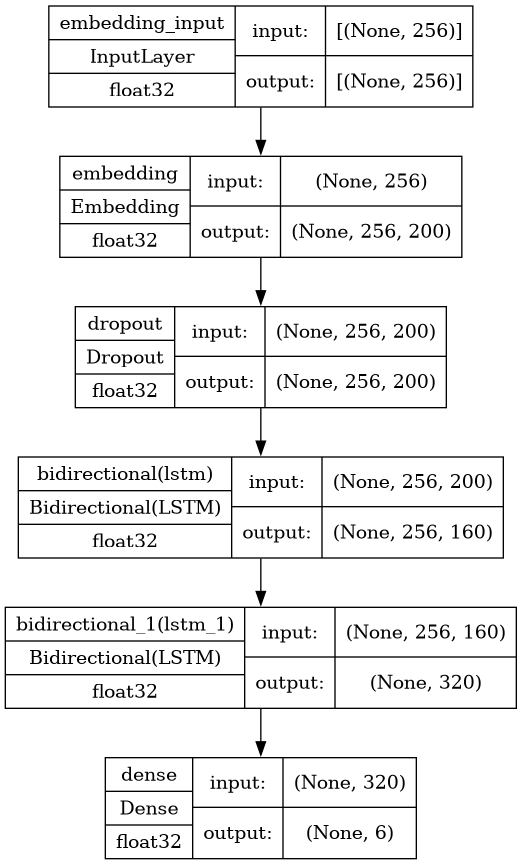

In [38]:
plot_model(
    model,
    to_file="tessa_bidirectional_lstm_model.png",
    show_shapes=True,
    show_dtype=True,
)

In [39]:
# Compile the model.

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [40]:
# Define the EarlyStopping callback function.
# Stop the training process if there is no improvement in the validation accuracy for 10 epochs,
# and it will restore the model weights from the epoch with the best validation accuracy.

early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=10, mode="auto", restore_best_weights=True
)

In [41]:
# Define the ReduceLROnPlateau callback function.
# Dynamically reduce the learning rate during the training by a factor of 0.5,
# if there is no improvement in the validation accuracy, with a minimum
# learning rate of 0.00001, and it will print a message for each update

reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, verbose=1, min_lr=0.00001
)

In [42]:
# Fit the model.

history_callback_object = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, reduce_learning_rate],
    validation_data=(X_valid, y_valid),
)

Epoch 1/100
499/499 [==============================] - 62s 105ms/step - loss: 0.9563 - accuracy: 0.6378 - val_loss: 0.3289 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 2/100
499/499 [==============================] - 32s 63ms/step - loss: 0.2253 - accuracy: 0.9204 - val_loss: 0.1598 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 3/100
499/499 [==============================] - 32s 64ms/step - loss: 0.1218 - accuracy: 0.9536 - val_loss: 0.1665 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 4/100
499/499 [==============================] - 31s 62ms/step - loss: 0.0914 - accuracy: 0.9670 - val_loss: 0.1726 - val_accuracy: 0.9338 - lr: 0.0010
Epoch 5/100
499/499 [==============================] - 30s 60ms/step - loss: 0.0692 - accuracy: 0.9728 - val_loss: 0.1801 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 6/100
499/499 [==============================] - 30s 60ms/step - loss: 0.0564 - accuracy: 0.9788 - val_loss: 0.2090 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 7/100
499/499 [==============================

In [43]:
# Loss graph.

fig = px.line(
    data_frame=history_callback_object.history,
    y=["loss", "val_loss"],
    labels={"index": "Epoch", "value": "Loss"},
    title="Loss vs Epoch",
)
fig.show()

history_callback_object.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [44]:
# Accuracy graph.

fig = px.line(
    data_frame=history_callback_object.history,
    y=["accuracy", "val_accuracy"],
    labels={"index": "Epoch", "value": "Accuracy"},
    title="Accuracy vs Epoch",
)
fig.show()

history_callback_object.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

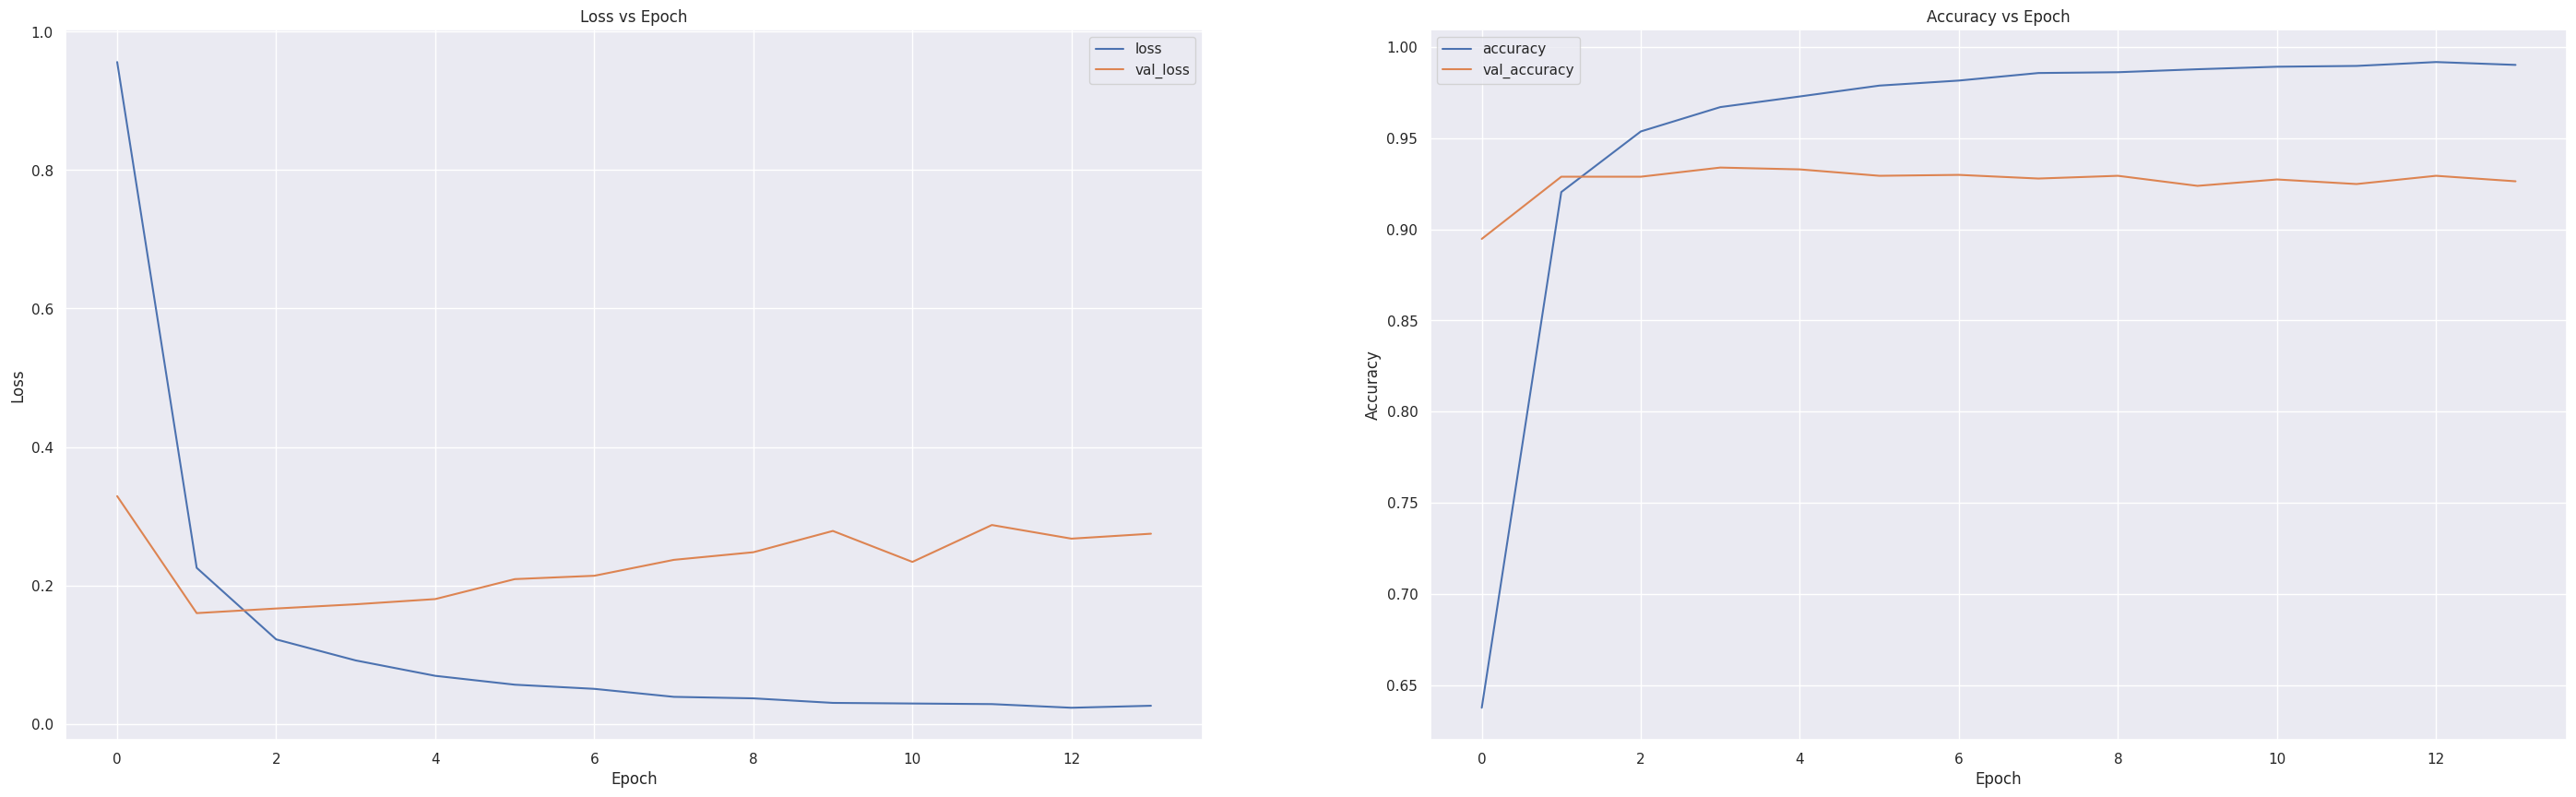

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [45]:
# Both loss and accuracy graphs side to side.

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history_callback_object.history["loss"], label="loss")
ax1.plot(history_callback_object.history["val_loss"], label="val_loss")
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss vs Epoch")
ax1.grid(True)

ax2.plot(history_callback_object.history["accuracy"], label="accuracy")
ax2.plot(history_callback_object.history["val_accuracy"], label="val_accuracy")
ax2.legend()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy vs Epoch")
ax2.grid(True)

fig.set_figheight(10)
fig.set_figwidth(35)
plt.show()

history_callback_object.history.keys()